In [1]:
import pandas as pd
import numpy as np
import model
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.features import Rank2D


In [2]:
sqlForTraining = """
select
	eta.idetablissement,
	eta.departement,
	eta.siren,
	eta.geores_lat,
	eta.geores_lon,
	eta.nb_agrements,
	eta.nb_inspections,
	CAST (eta.moy_score*10 AS INTEGER) as moy_score,
	eta.commune_norm,
	act.idactivite,
	act.categorie_frais,
	CASE 
      WHEN ins.synthese_eval = 'Très satisfaisant'  THEN 4
      WHEN ins.synthese_eval = 'Satisfaisant'  THEN 3
      WHEN ins.synthese_eval = 'A améliorer'  THEN 2
      WHEN ins.synthese_eval = 'A corriger de manière urgente'  THEN 1
	END	as synthese_eval
from inspection ins
join etablissement eta on ins.idetablissement = eta.idetablissement
join activite act on ins.idactivite = act.idactivite
order by eta.idetablissement
"""

In [3]:
df = pd.read_sql_query(sqlForTraining, model.session.connection())

df['moy_score'].astype('int')

#df = df.sample(frac=1).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35586 entries, 0 to 35585
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   idetablissement  35586 non-null  int64  
 1   departement      35586 non-null  int64  
 2   siren            35586 non-null  object 
 3   geores_lat       35586 non-null  float64
 4   geores_lon       35586 non-null  float64
 5   nb_agrements     35586 non-null  int64  
 6   nb_inspections   35586 non-null  int64  
 7   moy_score        35586 non-null  int64  
 8   commune_norm     35586 non-null  object 
 9   idactivite       35586 non-null  int64  
 10  categorie_frais  35586 non-null  bool   
 11  synthese_eval    35586 non-null  int64  
dtypes: bool(1), float64(2), int64(7), object(2)
memory usage: 3.0+ MB


In [4]:
X = df[[ 'commune_norm', 'geores_lat', 'geores_lon', 'siren', 'categorie_frais', 'nb_agrements', 'nb_inspections', 'departement', 'idactivite']]
X['categorie_frais'] = X['categorie_frais'].astype('int')

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
X['siren'] = labelencoder.fit_transform(X['siren'])
X['commune_norm'] = labelencoder.fit_transform(X['commune_norm'])

y = df['synthese_eval']

C:\Users\Nalshen\AppData\Local\Temp/ipykernel_9848/3709682832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['categorie_frais'] = X['categorie_frais'].astype('int')
C:\Users\Nalshen\AppData\Local\Temp/ipykernel_9848/3709682832.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['siren'] = labelencoder.fit_transform(X['siren'])
C:\Users\Nalshen\AppData\Local\Temp/ipykernel_9848/3709682832.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [5]:
print(np.unique(y, return_counts=True))

(array([1, 2, 3, 4], dtype=int64), array([  114,  1661, 18812, 14999], dtype=int64))


In [6]:
# X.info()

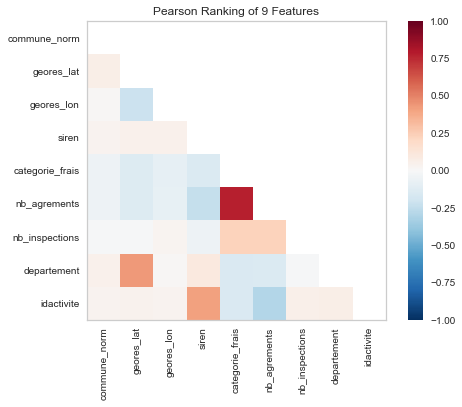

<AxesSubplot:title={'center':'Pearson Ranking of 9 Features'}>

In [7]:
r2D = Rank2D(algorithm='pearson')
r2D.fit(X)
r2D.transform(X)
r2D.show()

In [8]:
# print(np.corrcoef(X, rowvar=False))

# sns.pairplot(X)

In [9]:
# sns.pairplot(X[['geores_lat', 'geores_lon']])


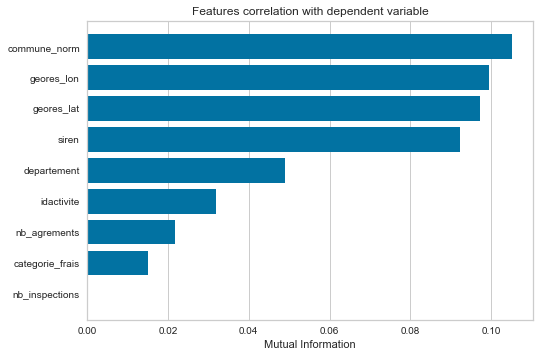

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [10]:
from yellowbrick.target import FeatureCorrelation
fc = FeatureCorrelation(method='mutual_info-regression', sort=True)
fc.fit(X, y, discrete_features=False)
fc.show()

In [11]:
# facilite entrainement et calcule des métrics ==> vu dans vid Ex corrigé Random Forest avec Sklearn de "EpiMed Open Source" : https://www.youtube.com/watch?v=ydk1mUqwsVQ
def calculate_accuracy(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
    accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
    print("Train accuracy", "{:.3f}".format(accuracy_train), "Test accuracy","{:.3f}".format(accuracy_test))
    return accuracy_train, accuracy_test, classifier

In [12]:
# Split du dataset pour train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42,stratify=y)

In [13]:
#vérification du split de la valeur y en %age
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

3    0.528623
4    0.421477
2    0.046688
1    0.003212
Name: synthese_eval, dtype: float64
3    0.528662
4    0.421506
2    0.046647
1    0.003185
Name: synthese_eval, dtype: float64


In [14]:
# Vérification répartition des échantillons
print ("Train : ", X_train.shape, "Test : ", X_test.shape)

Train :  (24910, 9) Test :  (10676, 9)


In [15]:
classifier_tree = DecisionTreeClassifier(random_state=42, class_weight="balanced")
classifier_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [16]:
classifier_tree.fit(X_train,y_train)
calculate_accuracy(classifier_tree, X_train, X_test, y_train, y_test)

Train accuracy 0.996 Test accuracy 0.578


(0.9956643918105179,
 0.5783064818284002,
 DecisionTreeClassifier(class_weight='balanced', random_state=42))

[Text(0.7281796074368129, 0.9871794871794872, 'geores_lon <= 6.859\ngini = 0.75\nsamples = 24910\nvalue = [6227.5, 6227.5, 6227.5, 6227.5]'),
 Text(0.46937426457647563, 0.9615384615384616, 'idactivite <= 158.5\ngini = 0.748\nsamples = 23983\nvalue = [4670.625, 5772.352, 6025.087, 5993.798]'),
 Text(0.18433807996374013, 0.9358974358974359, 'geores_lat <= 48.771\ngini = 0.698\nsamples = 8622\nvalue = [467.062, 1483.248, 2046.354, 2379.725]'),
 Text(0.11141933427611801, 0.9102564102564102, 'geores_lon <= 2.496\ngini = 0.693\nsamples = 5991\nvalue = [389.219, 953.134, 1256.566, 1869.021]'),
 Text(0.060184208627820396, 0.8846153846153846, 'nb_agrements <= 0.5\ngini = 0.635\nsamples = 3295\nvalue = [0.0, 444.439, 733.037, 985.818]'),
 Text(0.02359147898732249, 0.8589743589743589, 'geores_lat <= 45.08\ngini = 0.627\nsamples = 1367\nvalue = [0.0, 144.577, 357.533, 346.401]'),
 Text(0.005271393825449221, 0.8333333333333334, 'geores_lat <= 43.488\ngini = 0.636\nsamples = 359\nvalue = [0.0, 53.54

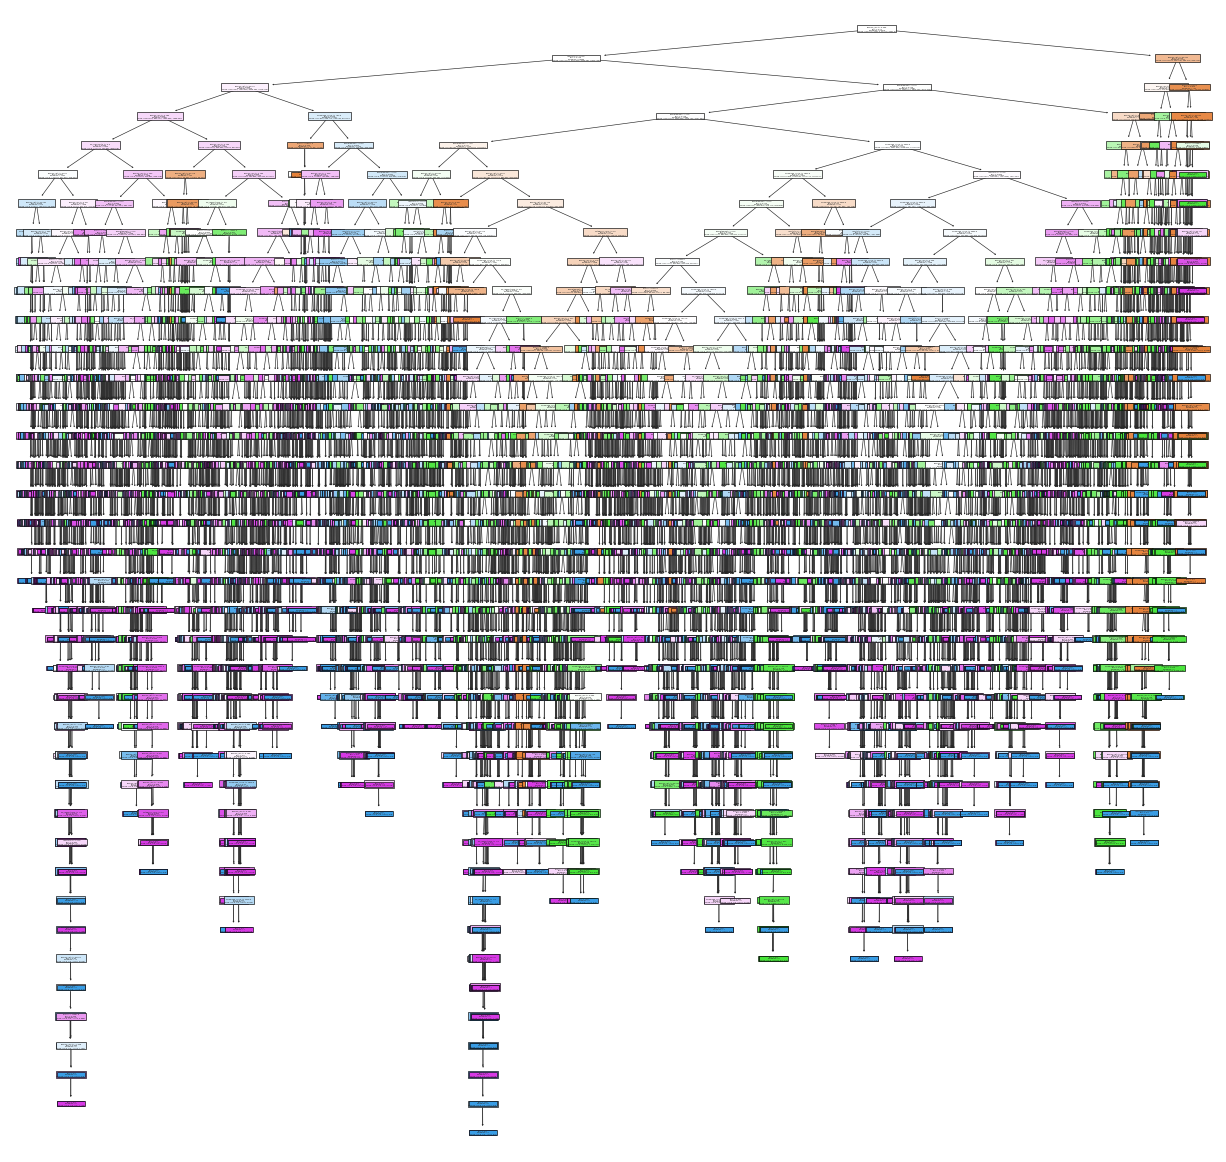

In [17]:
plt.figure(figsize=(10,10), dpi=150)
plot_tree(classifier_tree, feature_names=list(X_train.columns), filled=True)

D:\anaconda3\envs\AlimConfiance\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


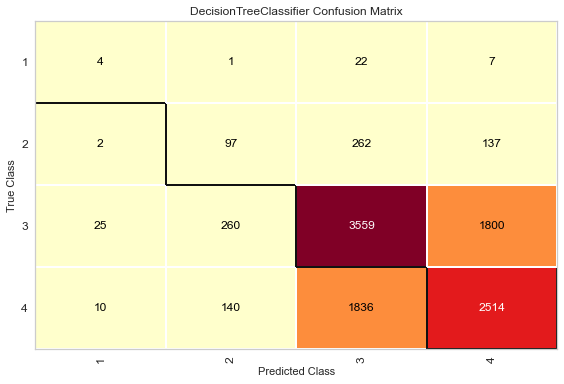

<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [18]:
clfConfusion = ConfusionMatrix(classifier_tree)
clfConfusion.score(X_test, y_test)
clfConfusion.show()

In [19]:
y_pred = classifier_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.10      0.12      0.11        34
           2       0.19      0.19      0.19       498
           3       0.63      0.63      0.63      5644
           4       0.56      0.56      0.56      4500

    accuracy                           0.58     10676
   macro avg       0.37      0.38      0.37     10676
weighted avg       0.58      0.58      0.58     10676



In [36]:
classifier_tree_2 = DecisionTreeClassifier(max_depth=35,random_state=42, class_weight="balanced")
classifier_tree_2.get_params()
classifier_tree_2.fit(X_train,y_train)
calculate_accuracy(classifier_tree_2, X_train, X_test, y_train, y_test)

Train accuracy 0.995 Test accuracy 0.579


(0.995463669209153,
 0.5793368302735107,
 DecisionTreeClassifier(class_weight='balanced', max_depth=35, random_state=42))

In [37]:
y_pred_2 = classifier_tree_2.predict(X_test)
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           1       0.10      0.12      0.11        34
           2       0.20      0.20      0.20       498
           3       0.63      0.63      0.63      5644
           4       0.57      0.56      0.56      4500

    accuracy                           0.58     10676
   macro avg       0.37      0.38      0.37     10676
weighted avg       0.58      0.58      0.58     10676

